In [1]:
import os
import shutil

import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import mlflow
from mlflow.models.signature import infer_signature
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from settings import params, model_name, folders
from functions.image.img_analysis import get_images_info
from functions.image.img_treatment import prepare_data
from functions.visualizations.img_show import show_images
from functions.visualizations.show_predictions import show_predictions
from functions.data import get_train_test
import functions.models

# Sets the number of threads
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(12)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [ ]:
# Download latest version of dataset and store it locally
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

target_dir = "data"
os.makedirs(target_dir, exist_ok=True)
shutil.move(path, target_dir)
removable_folder_paths = ("data/chest_xray/", "data/2/chest_xray/chest_xray")
for folder_path in removable_folder_paths:
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)

In [ ]:
# Analyser les images
df_train_images = get_images_info(folders["train"]["input"])
df_train_valid = df_train_images[df_train_images["error"] == False]

# Identifier les images extrêmes
extremes = pd.concat([
    df_train_valid.loc[df_train_valid["width"].idxmax()],
    df_train_valid.loc[df_train_valid["width"].idxmin()],
    df_train_valid.loc[df_train_valid["height"].idxmax()],
    df_train_valid.loc[df_train_valid["height"].idxmin()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmax()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmin()],
], axis=1).T.drop_duplicates()

# Aperçu
print(df_train_images.head())
# Statistiques
print(df_train_images.describe())
# Affichage en tableau
print("\nImages aux valeurs extrêmes :")
print(extremes.sort_values(by=["width", "height"], ascending=[False, False]))

# Effectif de chaque catégorie d'entrainement: le dataset est déséquilibré
split_path = "data/2/chest_xray/train"
for category in ["NORMAL", "PNEUMONIA"]:
    category_path = split_path + '/' + category
    count = len([
            f for f in os.listdir(category_path)
        ])
    print(f"{category}: {count} images")

# Affichage des images extrêmes
show_images(extremes.reset_index(drop=True), folder_path=folders["train"]["input"])

In [ ]:
# Transformation des images
for folder in folders:
    prepare_data(folders[folder]["input"], folders[folder]["output"])

In [2]:
# Préparation des données de travail
X_train, y_train = get_train_test(folders["train"]["output"])
X_test, y_test = get_train_test(folders["test"]["output"])
X_val, y_val = get_train_test(folders["val"]["output"])

# Rééquilibrage du dataset
class_weight_dict = {0: 1.0, 1: 1.0}
if params["equilibrate"]:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Echantillonnage pour vérification
# Sélectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices sélectionnés
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [3]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

#Transform y_train, y_test to the shape expected by the model
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# On n'aplatit pas maintenant car les convolution ont besoin de matrices

In [4]:
# Création du modèle
model = functions.models.initialize_vgg16_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Entrainement du modèle
model_info = model.fit(
    X_train, y_train,
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.6416 - auc: 0.6936 - loss: 0.6438 - mean_squared_error: 0.2207 - precision: 0.6416 - recall: 0.6416 - val_accuracy: 0.5625 - val_auc: 0.5352 - val_loss: 4.1059 - val_mean_squared_error: 0.4407 - val_precision: 0.5625 - val_recall: 0.5625
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.8836 - auc: 0.9498 - loss: 0.3660 - mean_squared_error: 0.0871 - precision: 0.8836 - recall: 0.8836 - val_accuracy: 0.5625 - val_auc: 0.5352 - val_loss: 7.7378 - val_mean_squared_error: 0.4469 - val_precision: 0.5625 - val_recall: 0.5625
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.9024 - auc: 0.9648 - loss: 0.2748 - mean_squared_error: 0.0708 - precision: 0.9024 - recall: 0.9024 - val_accuracy: 0.5000 - val_auc: 0.5312 - val_loss: 9.1809 - val_mean_squared_error: 0.4788 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.9161 - auc: 0.9717 - loss:

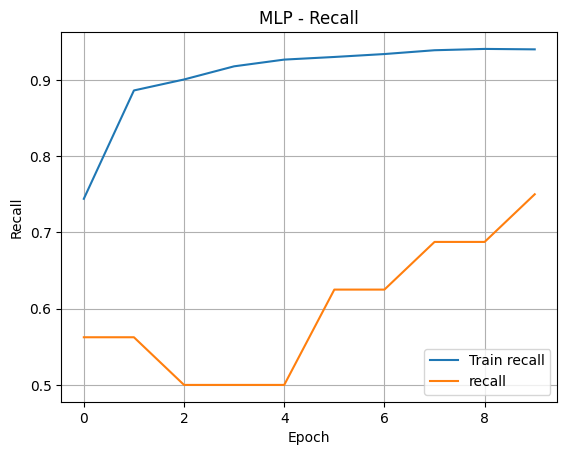

In [7]:
# Résultats d'entraînement du modèle
plt.plot(model_info.history["recall"], label='Train recall')
plt.plot(model_info.history["val_recall"], label='recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title("MLP - Recall")
plt.legend()
plt.grid(True)
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 908ms/step


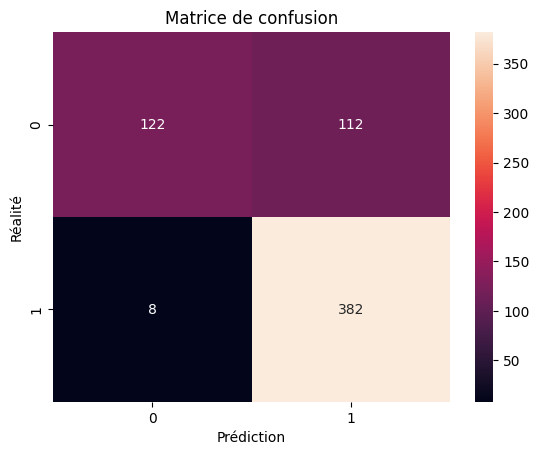

In [12]:
y_pred = model.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

sns.heatmap(conf_matrix, fmt='d', annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

In [13]:
# Log results
results = {}
results["loss"], results["recall"], results["accuracy"], results["precision"], results["auc"], results["mean_squared_error"] = model.evaluate(X_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 863ms/step - accuracy: 0.6702 - auc: 0.7361 - loss: 0.7693 - mean_squared_error: 0.2766 - precision: 0.6702 - recall: 0.6702


In [15]:
# Log into MLFlow
mlflow.set_experiment("Initial testing")
mlflow.set_tracking_uri("http://localhost:5000/")

with mlflow.start_run() as run:
    run_id = run.info.run_id

    mlflow.log_params(params)
    mlflow.log_metrics(
        results
    )
    mlflow.tensorflow.log_model(
            model=model,
            artifact_path=model_name,
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )
    model_uri = f"runs:/{run_id}/{model_name}"
    mlflow.register_model(model_uri=model_uri, name=model_name)

MlflowException: Cannot set a deleted experiment 'Initial testing' as the active experiment. You can restore the experiment, or permanently delete the experiment to create a new one.

In [ ]:
# Load a model
model_name = input("Enter model name")
model_version = int(input("Enter model version"))
alias = "challenger"

model_uri = f"models:/{model_name}/{model_version}"

loaded_model = mlflow.tensorflow.load_model(model_uri)

y_pred = loaded_model.predict(X_val)
show_predictions(X_val, y_pred, y_true=y_val, class_names=["normal", "malade"], n_images=10)